# Configuration

Import here the libraries you will need

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Define the functions you will use later

In [ ]:
#Gráfico de Lineas
def graph_line(ts_,values,xlabel_,ylabel_,dpi_,color_,title_):
  plt.figure(figsize=(10,3), dpi=dpi_)
  plt.plot(ts_.index, ts_[values], color=color_)
  plt.title(title_)
  plt.xlabel(xlabel_)
  plt.ylabel(ylabel_)
  plt.show()
#Definición de una lista de colores
def color_list(ts):
 cant=len(ts)
 np.random.seed(100)
 colors=np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cant, replace=False)
 return colors

#Test estacionario de parámetros estadisticos móviles

def test_stat_roll_param(ts,N,col):
 #visualizando gráfica
 mpl.rcParams['figure.figsize'] = 8,3
 ts=ts.dropna()
 roll_mean=ts[col].rolling(window=N).mean()
 roll_var=ts[col].rolling(window=N).var()
 plt.plot(ts.index, roll_mean, color="green", label="rolling mean")
 plt.plot(ts.index, roll_var, color="red", label="rolling variance")
 plt.legend(loc="best")
 plt.title("Rolling mean & Variance")

def test_stat_roll_param_1(ts,N,col):
 #dividiendo la serie en partes iguales
 split=round(len(ts[col].values)/2)
 df=ts
 part_1,part_2=df[col].values[0:split],df[col].values[split:]
 mean_1,mean_2 = part_1.mean(),part_2.mean()
 var_1,var_2=part_1.var(),part_2.var()
 print("mean_1st_part: %f " %(mean_1),"var_1st_part: %f " %(var_1))
 print("mean_2nd_part:%f" %(mean_2),"var_2nd_part: %f " %(var_2))

#test de hipotésis
def adfuller_test(ts, col, significance):
 result_adf=adfuller(ts[col])
 # Print values
 print('ADF Statistic: %f' % result_adf[0])
 print('p-value: %f' % result_adf[1])
 print('Critical Values:')
 for key, value in result_adf[4].items():
	 print('\t%s: %.3f' % (key, value))
 #Result
 if((result_adf[1] <= significance) and (result_adf[0] <= list(result_adf[4].items())[1][1])): 
    print('We can reject the null hypothesis. Time series is stationary')
 else: print('Time series is not stationary')
  
  
#test de autocorrelación
def auto_corr(ts,col):
 print("Autocorrelaciòn: %.3f " %(ts[col].autocorr()))
 plot_acf(ts[col]);

#visualizacion de residuos de modelos de predicción
def model_summary_results(model_fitted):
    # Model summary
    print(model_fitted.summary())
    
    # Model residuals
    residuals = pd.DataFrame(model_fitted.resid)
    residuals = residuals.reset_index()
    residuals = residuals.drop(['new_date'], axis=1)
    residuals.columns = ['residuals']

    # Plot
    plt.figure(figsize=(10,4))
    plt.subplot(121) 
    plt.plot(residuals)
    plt.title('Residuals')
    plt.subplot(122) 
    sns.kdeplot(data=residuals, x="residuals")
    plt.title('Density')
    plt.show()
    
#obtener el orden del modelo    
def obtain_order_model(ts):
    # Obtain ACF and PCSF
    lag_acf = acf(ts, nlags=20, fft = True)
    lag_pacf = pacf(ts, nlags=20, method='ols')#“ols”: regresión de series de tiempo sobre rezagos de la misma y sobre constante.

    plt.figure(figsize=(8,4))
    #Plot ACF:    
    plt.subplot(121)    
    plt.plot(lag_acf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')#axhline es para agregar una linea horizontal que en este caso son las lineas de confianza
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

#predicción
def forecasting(model_fitted, n_preds, data_test, data_train, title):
  # Predict
  forecast = model_fitted.forecast(n_preds, alpha=0.05)

  # Convert predictions to series
  fc_series = pd.Series(forecast, index=data_test.index)

  # Plot
  plt.figure(figsize=(10, 4), dpi=100)
  plt.plot(data_train, label='Training')
  plt.plot(data_test, linestyle="dashed",label='Actual')
  plt.plot(fc_series, linewidth=2,label='Forecast')
  plt.title(title)
  plt.legend(loc='upper left', fontsize=8)
  plt.show()  

#Obtener la acurracy del modelo
def forecast_accuracy(predicted, real):
    me = np.mean(predicted - real)                         # ME
    mae = np.mean(np.abs(predicted - real))                # MAE
    mape = np.mean(np.abs(predicted - real)/np.abs(real))  # MAPE
    rmse = np.mean((predicted - real)**2)**.5              # RMSE
    print({'me':me, 'mae': mae, 'mape':mape, 'rmse':rmse})

Define the variables you will use later

# Final exercise

Load the ts from the folder data_for_final_exercise and answer the following questions

In [ ]:
dateparse=lambda date: dt.datetime.strptime(date,"%Y-%m-%d")
ts=pd.read_csv('aemet_year_month.csv', sep=';', parse_dates=["new_date"], date_parser=dateparse, index_col="new_date")
ts.head(10)


,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2
2013-06-01,21886.2,5392.1,5400.1,5654.4,6314.1
2013-07-01,12508.8,1863.3,801.9,3006.0,7135.5
2013-08-01,13331.8,2288.7,2483.6,3927.3,5233.9
2013-09-01,23053.8,4188.3,4840.3,6940.1,8206.9
2013-10-01,41867.0,11322.0,10506.4,11092.0,10385.9
2013-11-01,43964.0,11560.0,12931.5,10595.5,10314.6
2013-12-01,47036.3,10889.2,14196.5,12830.7,10776.1
2014-01-01,63607.5,16789.9,16384.7,15284.2,17099.0


In [ ]:
ts.info()
ts_1=ts.copy()
ts_1=ts_1.asfreq("MS") #Es una frecuencia mensual
print("\nNulos\n ",ts_1.isnull().sum())
print("\nShape: ",ts_1.shape)
print("\nduplicated: ",ts_1.index.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2013-05-01 to 2018-08-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rain_all    64 non-null     float64
 1   rain_00_06  64 non-null     float64
 2   rain_06_12  64 non-null     float64
 3   rain_12_18  64 non-null     float64
 4   rain_18_24  64 non-null     float64
dtypes: float64(5)
memory usage: 3.0 KB

Nulos
  rain_all      0
rain_00_06    0
rain_06_12    0
rain_12_18    0
rain_18_24    0
dtype: int64

Shape:  (64, 5)

duplicated:  0


1.- Which is the **format** of the date variable? What **frequency** does it have?

In [ ]:
print("Su formato es:", ts.index[0].strftime)#su formato es:"%Y-%m-%d"
print("Su frecuencia es: ", ts_1.index.freqstr)#su frecuencia es mensual MS


Su formato es: <bound method Timestamp.strftime of Timestamp('2013-05-01 00:00:00')>
Su frecuencia es:  MS


2.- Does the ts follow an **additive or a multiplicative** model?

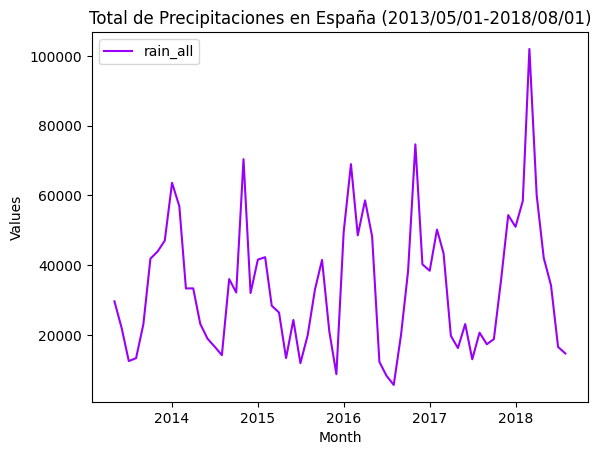

In [ ]:
#Gráfica según total de precipitación
colors_list=color_list(ts_1.index)
plt.plot(ts_1.index, ts_1.loc[:,"rain_all"],label=ts_1.columns[0],color=colors_list[0])
plt.legend(loc="best")
plt.xlabel("Month")
plt.ylabel("Values")
plt.title("Total de Precipitaciones en España (2013/05/01-2018/08/01)")
plt.show()


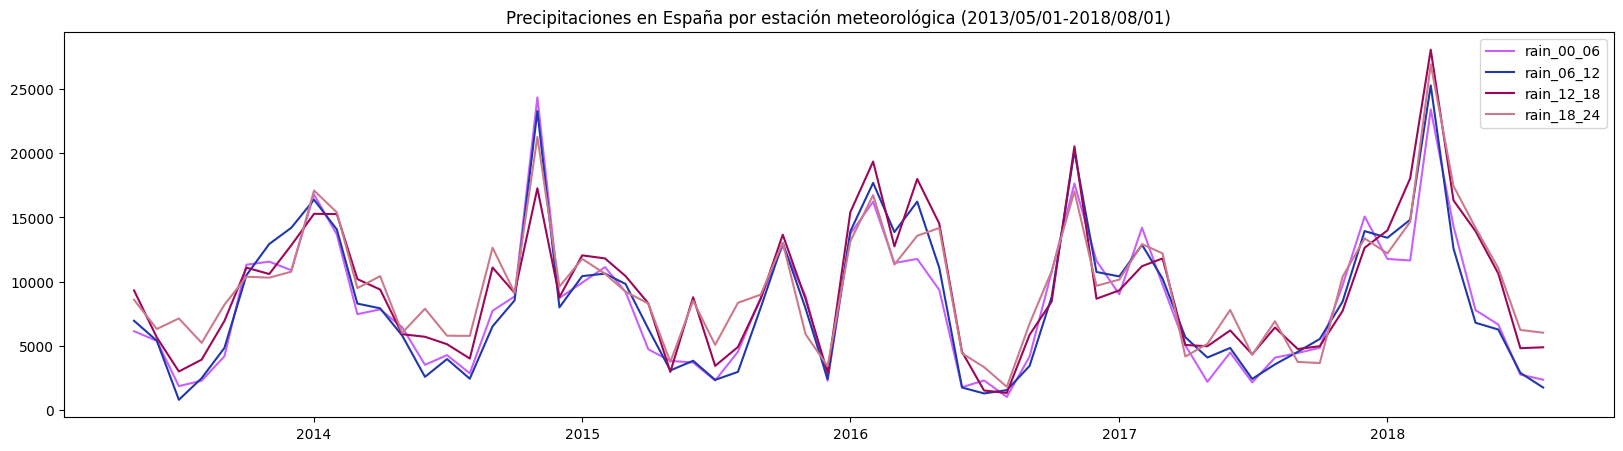

In [ ]:
#Gráfica precipitación por estación
plt.figure(figsize=(20,5), dpi=100)
plt.plot(ts_1.index, ts_1.loc[:,"rain_00_06"],color=colors_list[1],label=ts_1.columns[1])
plt.plot(ts_1.index, ts_1.loc[:,"rain_06_12"],color=colors_list[2],label=ts_1.columns[2])
plt.plot(ts_1.index, ts_1.loc[:,"rain_12_18"],color=colors_list[3],label=ts_1.columns[3])
plt.plot(ts_1.index, ts_1.loc[:,"rain_18_24"],color=colors_list[4],label=ts_1.columns[4])
plt.legend(loc="best")
plt.title("Precipitaciones en España por estación meteorológica (2013/05/01-2018/08/01)")
plt.show()

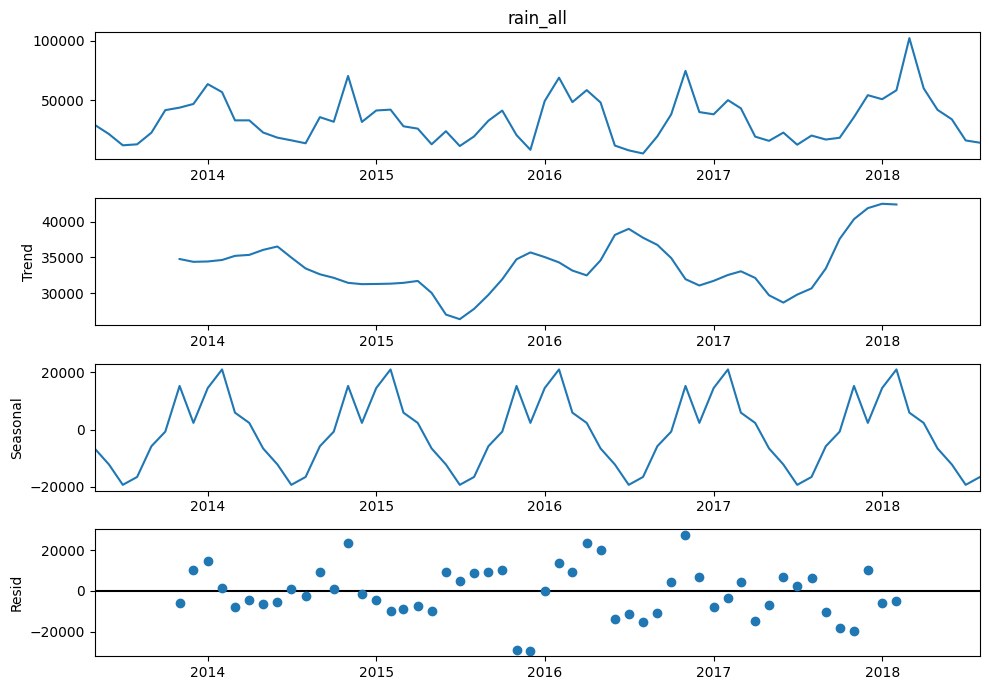

In [ ]:
#Descomposición modelo Aditivo
from statsmodels.tsa.seasonal import seasonal_decompose
mpl.rcParams["figure.figsize"]=10,7
ts_1_decompose_add = seasonal_decompose(ts_1.rain_all, model="additive")
ts_1_decompose_add.plot();

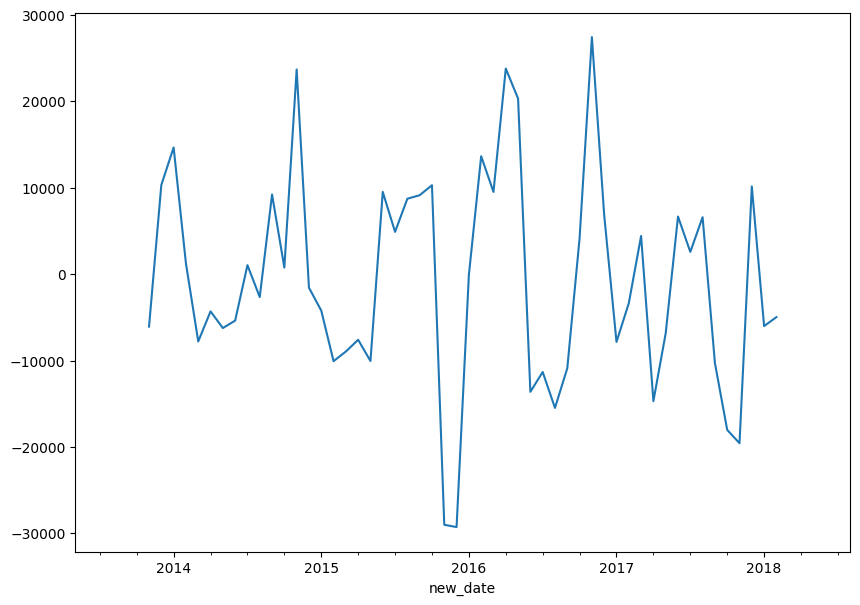

In [ ]:
#residuo del modelo aditivo
ts_1_decompose_add.resid.plot();

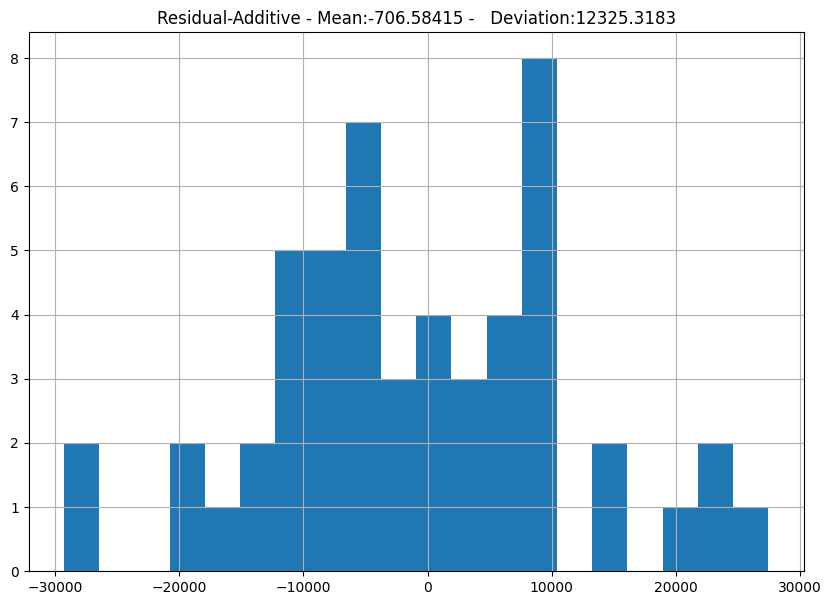

In [ ]:
ts_1_decompose_add.resid.hist(bins=20);
plt.title(f"Residual-Additive - Mean:{round(ts_1_decompose_add.resid.mean(), 5)} - \
  Deviation:{round(ts_1_decompose_add.resid.std(), 5)}");




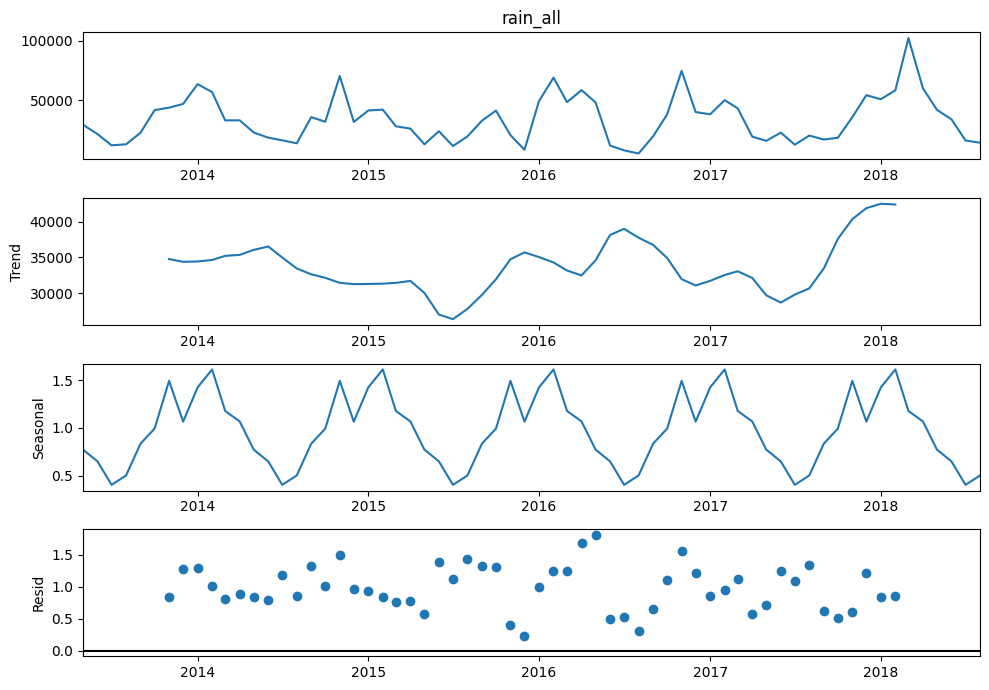

In [ ]:
#descomposición modelo multiplicativo
mpl.rcParams["figure.figsize"]=10,7
ts_1_decompose_mult = seasonal_decompose(ts_1.rain_all, model="multiplicative")
ts_1_decompose_mult.plot();

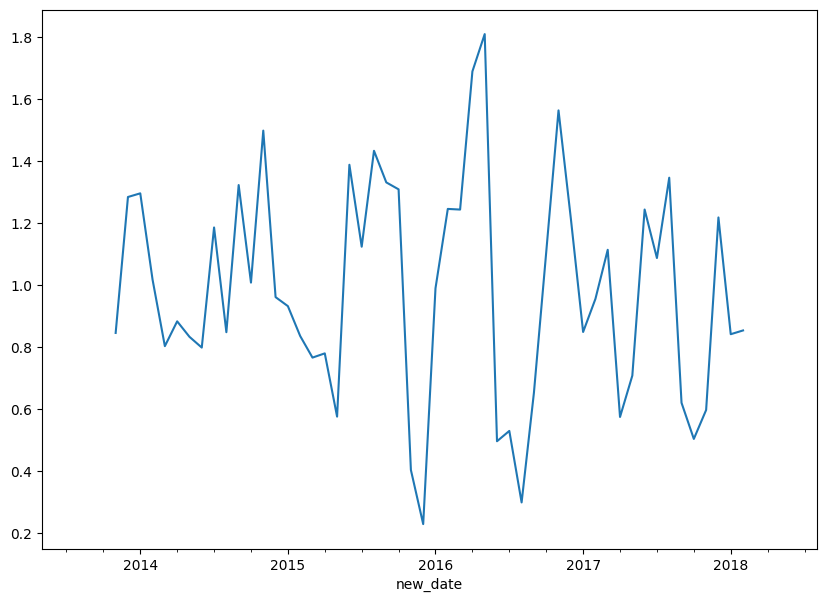

In [ ]:
ts_1_decompose_mult.resid.plot();



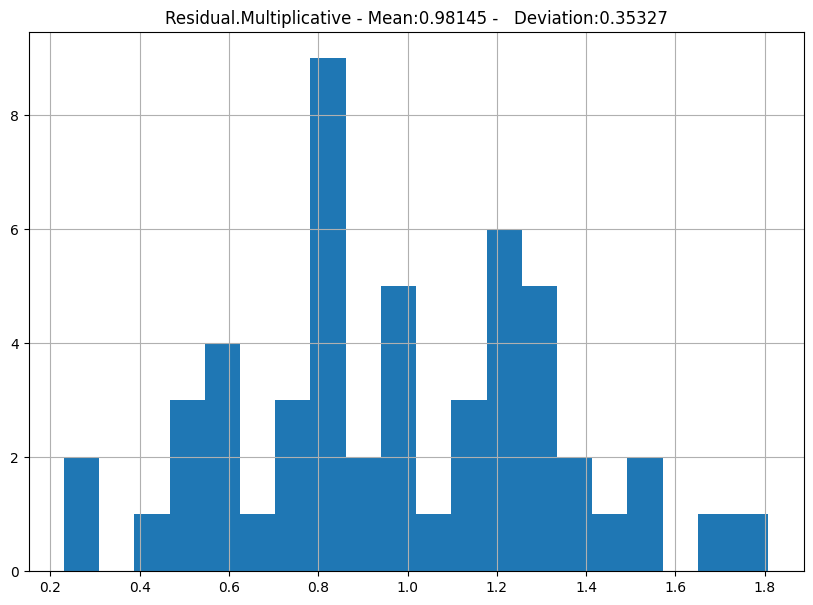

In [ ]:
ts_1_decompose_mult.resid.hist(bins=20);
plt.title(f"Residual.Multiplicative - Mean:{round(ts_1_decompose_mult.resid.mean(), 5)} - \
  Deviation:{round(ts_1_decompose_mult.resid.std(), 5)}");


***Se observa que es un modelo multiplicativo; al comparar las variaciones de los residuos de ambos modelos, en ninguno se aprecia un patrón, en el aditivo se observan 
valores sumamente altos, cuya desviación es de 12325 y su media es -706, mientrás que en el multiplicativo la variación tiende a hacer menor y mejor, y esta centrado en 1 aproximadamente. ***

3.- **Decompose** the ts, can you observe a **trend** or a **seasonal component**?

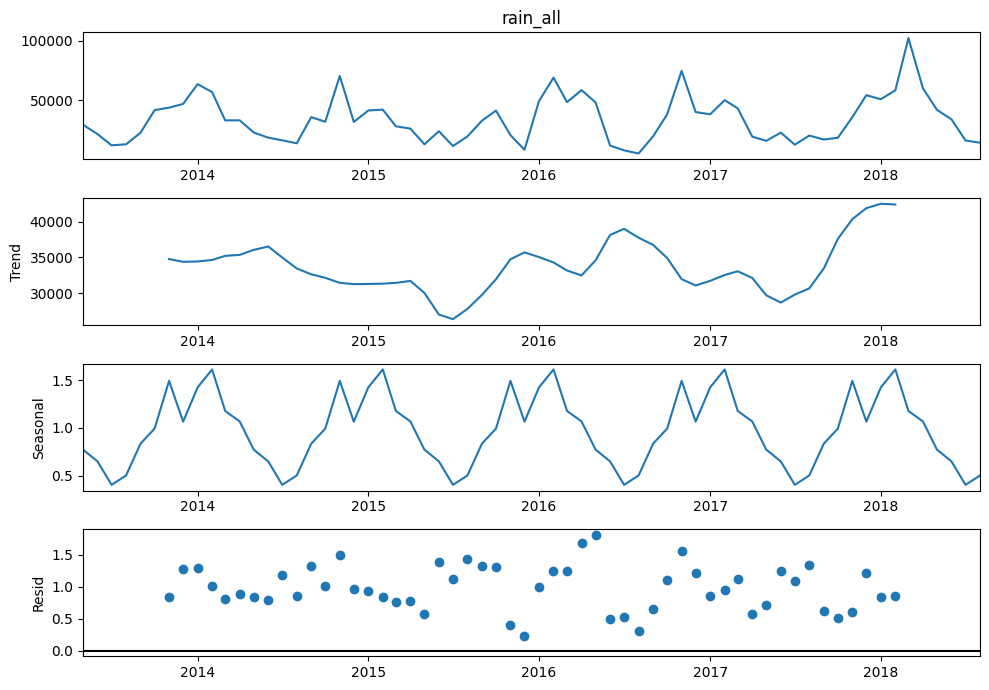

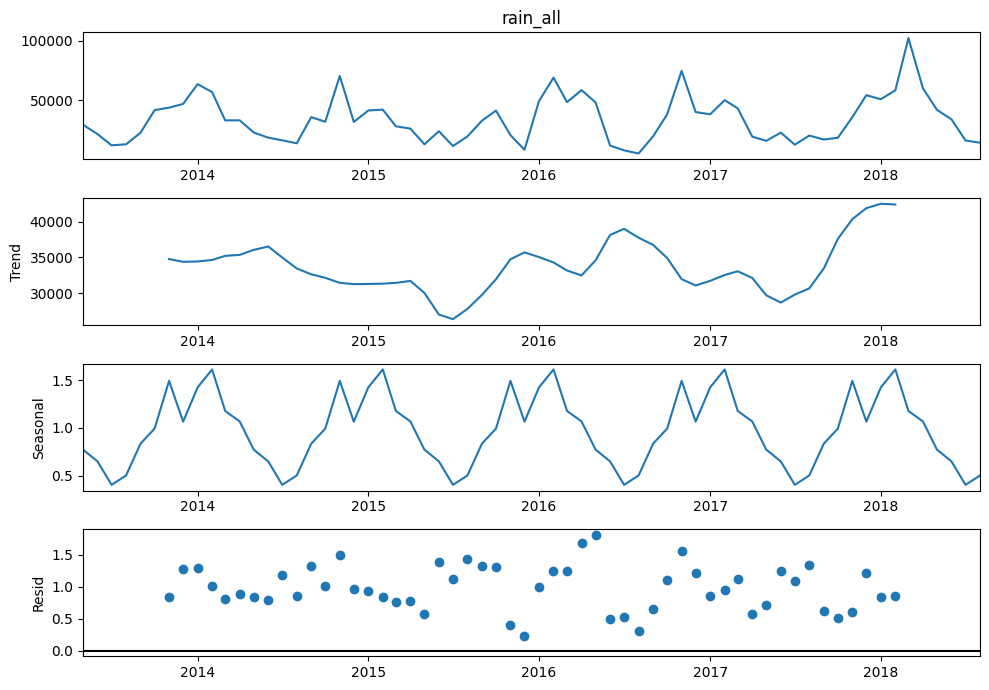

In [ ]:
ts_1_decompose_mult.plot()
#Se observa que hay una componente estacionaria no tan fuerte y también una tendencia es apreciada.



4.- Is it **stationary**? If not, which **steps** did you apply to make it stationary?

mean_1st_part: 30516.615625  var_1st_part: 224374870.033193 
mean_2nd_part:37618.412500 var_2nd_part: 481174784.897968 


'se observa que no es estacionaria, algo que se esperaba al tener componentes de tendencia y estacionalidad, ya que los parámetros estadisticos difieren en las partes divididas de la serie,\nademás que en el gráfico se aprecia que la variación no es constante'

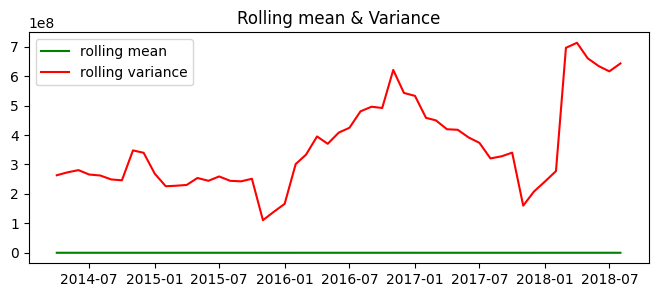

In [ ]:
#Test estacionario de parámetros estadisticos móviles
test_stat_roll_param(ts_1,12,"rain_all")
test_stat_roll_param_1(ts_1,12,"rain_all")

"""se observa que no es estacionaria, algo que se esperaba al tener componentes de tendencia y estacionalidad, ya que los parámetros estadisticos difieren en las partes divididas de la serie,
además que en el gráfico se aprecia que la variación no es constante"""

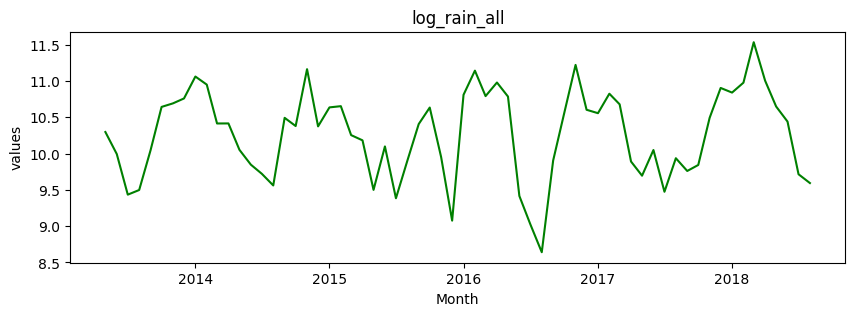

In [ ]:
#Convirtiendo la serie en estacionaria
ts_2=ts_1.copy()

#Aplicando estrategias
"""Logaritmo"""
ts_2["log_rain_all"]=np.log(ts_2.rain_all)
graph_line(ts_2,"log_rain_all","Month","values",100,"green","log_rain_all")

In [ ]:
#Testeando si es estacionaria luego de aplicar la transformación LOG
adfuller_test(ts_2.dropna(), "log_rain_all", 0.05)

#Es estacionaria segùn el test!!

ADF Statistic: -4.572696
p-value: 0.000145
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
We can reject the null hypothesis. Time series is stationary


Autocorrelaciòn: 0.593 


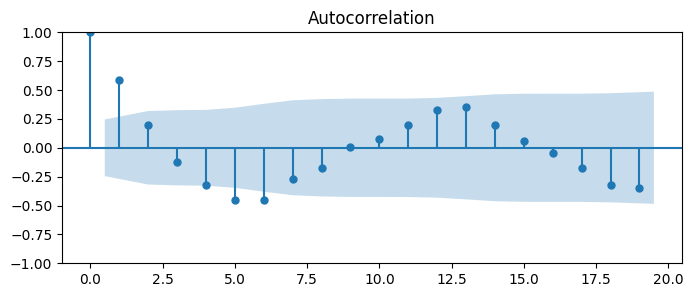

In [ ]:
auto_corr(ts_2.dropna(),"log_rain_all")
#Solo se observa dos p-value (del primero siempre se espera que sea asì) afuera del umbral de confianza, lo que determina que no hay autocorrelación

mean_1st_part: 10.201874  var_1st_part: 0.261338 
mean_2nd_part:10.334866 var_2nd_part: 0.460217 


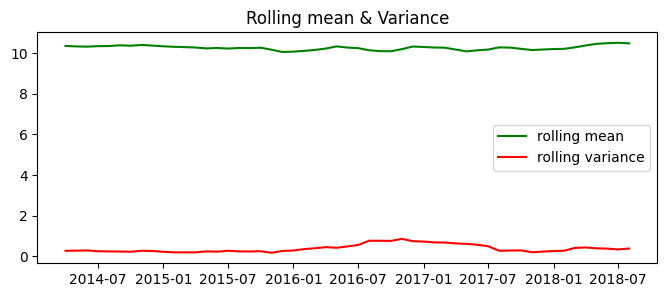

In [ ]:
test_stat_roll_param(ts_2.dropna(),12,"log_rain_all")
test_stat_roll_param_1(ts_2.dropna(),12,"log_rain_all")
#los valores son cercanos, las cuatro pruebas determinan que es estacionaria luego de aplicar la transformación LOG.


5.- Build a **benchmark** model to predict the last 8 periods. Choose an **error measurement** and obtain the error of the prediction.

In [ ]:
#separando los datos en train y test
ts_2_train=ts_2[:-8]
ts_2_test=ts_2[-8:]
print(ts_2_train.shape,ts_2_test.shape, ts_2.log_rain_all.shape)
print(ts_2_train.tail(1).index,ts_2_test.head(1).index)


(56, 6) (8, 6) (64,)
DatetimeIndex(['2017-12-01'], dtype='datetime64[ns]', name='new_date', freq='MS') DatetimeIndex(['2018-01-01'], dtype='datetime64[ns]', name='new_date', freq='MS')


<ipython-input-22-692615a7b294>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_2_test['y_hat_mean_last_n']=ts_2_train.log_rain_all.rolling(8).mean().iloc[-1]
<ipython-input-22-692615a7b294>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_2_test['y_hat_naive_seasonal']=ts_2_train["log_rain_all"].iloc[-8:].values


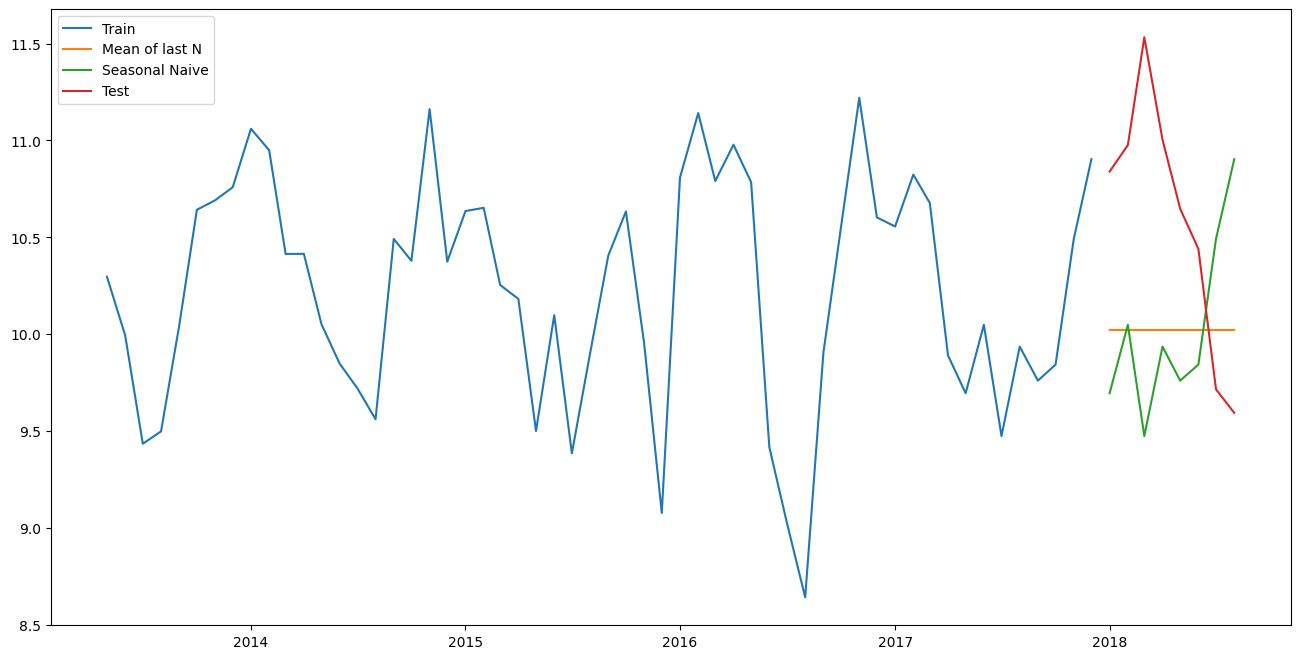

In [ ]:
"""Benchmark Model"""
#Trabajaré con la serie ya transformada a estacionara en todos los modelos 

#La media de los últimos periodos
ts_2_test['y_hat_mean_last_n']=ts_2_train.log_rain_all.rolling(8).mean().iloc[-1]
#El último patrón periódico o seasonal naive
ts_2_test['y_hat_naive_seasonal']=ts_2_train["log_rain_all"].iloc[-8:].values

plt.figure(figsize=(16,8))
plt.plot(ts_2_train["log_rain_all"], label='Train')
plt.plot(ts_2_test['y_hat_mean_last_n'], label='Mean of last N')
plt.plot(ts_2_test['y_hat_naive_seasonal'], label='Seasonal Naive')
plt.plot(ts_2_test['log_rain_all'], label='Test')
plt.legend(loc='best')
plt.show()

#estas variables las usaré luego para realizar un dataframe con las predicciones de todos los modelos
forecast_BANCHMARK_y_hat_mean_last_n=ts_2_test['y_hat_mean_last_n']
forecast_BANCHMARK_y_hat_naive_seasonal=ts_2_test['y_hat_naive_seasonal']

In [ ]:
#Obteniendo el error de los modelos benchmark
forecast_accuracy(ts_2_test['y_hat_mean_last_n'], ts_2_test.log_rain_all) # me enfocaré en el mape, se que para trabajar
forecast_accuracy(ts_2_test.y_hat_naive_seasonal, ts_2_test.log_rain_all)

#Se observa que el mape de y_hat_mean_last_n es un modelo muy bueno al ser < 0.1, el de y_hat_naive_seasonal es bueno al estar entre 0.1 y 0.2

{'me': -0.5746324875774589, 'mae': 0.7570040377053402, 'mape': 0.06984041597388349, 'rmse': 0.8439288701432301}
{'me': -0.5746324875774582, 'mae': 1.0964225209304481, 'mape': 0.10285325607298633, 'rmse': 1.1734342099276267}


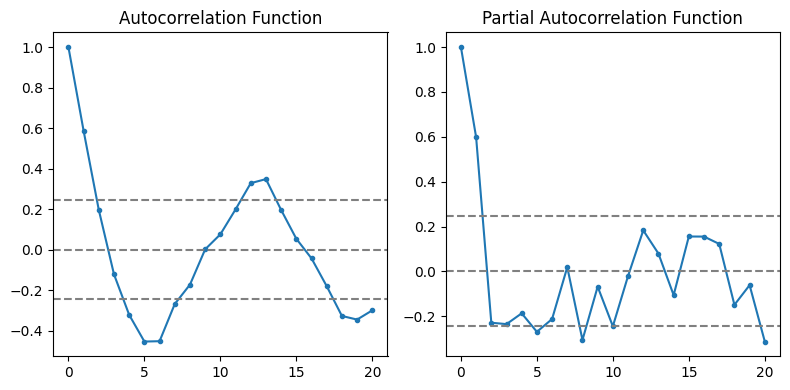

In [ ]:
obtain_order_model(ts_2.log_rain_all.dropna())

6.- Build an **AR** or a **MA** model. How does the **error** change?

                               SARIMAX Results                                
Dep. Variable:           log_rain_all   No. Observations:                   56
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -38.563
Date:                Mon, 05 Jun 2023   AIC                             85.126
Time:                        18:28:21   BIC                             93.227
Sample:                    05-01-2013   HQIC                            88.266
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2318      0.123     83.185      0.000       9.991      10.473
ar.L1          0.6674      0.133      5.008      0.000       0.406       0.929
ar.L2         -0.2350      0.148     -1.589      0.1

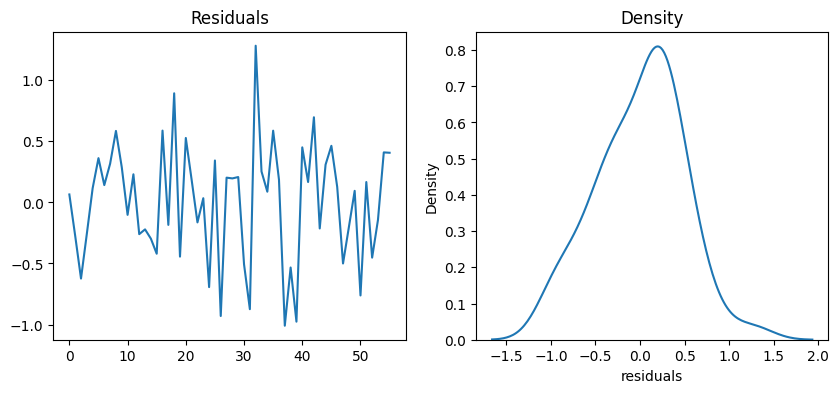

In [ ]:
#Modelo AR
model_ar=ARIMA(ts_2_train.log_rain_all.dropna(), order=(2,0,0))#usaré 2 al ver el pacf y acf donde el último delta significativo es 2
model_ar_fitted=model_ar.fit()
print(model_ar_fitted.summary())

#visualizando los residuos
model_summary_results(model_ar_fitted)
#no se observan patrones, y es similar a una distribución gaussiana



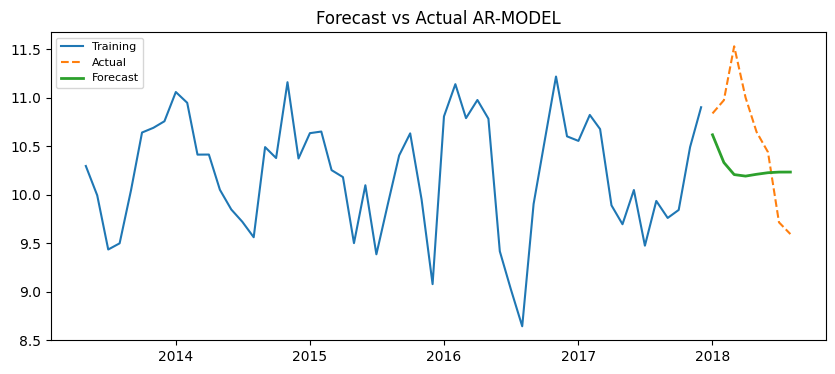

In [ ]:
#realizando predicción con el modelo AR
forecasting(model_ar_fitted, 8, ts_2_test.log_rain_all, ts_2_train.log_rain_all,"Forecast vs Actual AR-MODEL")
forecast_AR = model_ar_fitted.forecast(8, alpha=0.05)


In [ ]:
#Observando el error
forecast_accuracy(forecast_AR, ts_2_test.log_rain_all)
#Se observa que el error es menor en comparación de los modelos benchmark

{'me': -0.31144605818797366, 'mae': 0.6012582625654752, 'mape': 0.056154889706340104, 'rmse': 0.688558311034097}


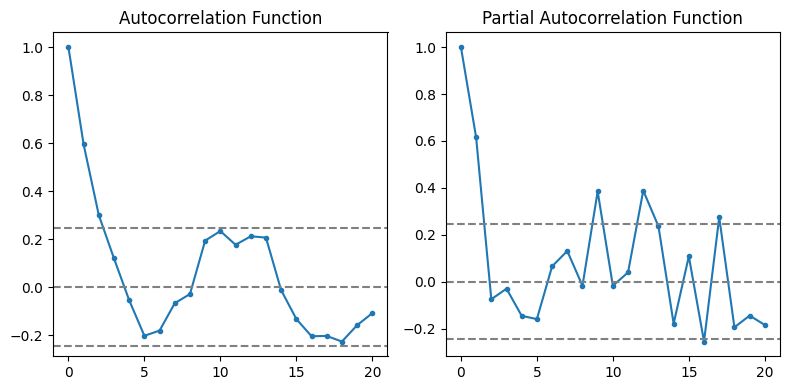

In [ ]:
obtain_order_model(pd.concat([ts_2_train.rain_all,forecast_AR.dropna()]))

                               SARIMAX Results                                
Dep. Variable:           log_rain_all   No. Observations:                   56
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 -38.222
Date:                Mon, 05 Jun 2023   AIC                             84.444
Time:                        18:28:25   BIC                             92.545
Sample:                    05-01-2013   HQIC                            87.584
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2348      0.138     74.136      0.000       9.964      10.505
ma.L1          0.6652      0.155      4.284      0.000       0.361       0.970
ma.L2          0.3536      0.117      3.032      0.0

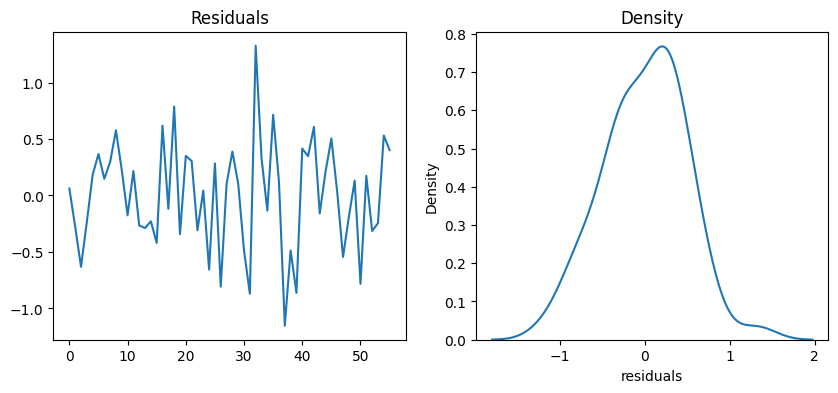

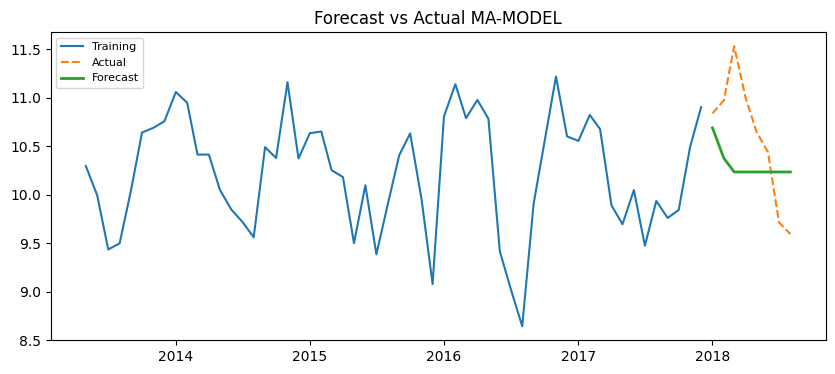

In [ ]:
#modelo MA
model_ma=ARIMA(ts_2_train.log_rain_all.dropna(), order=(0,0,2))
model_ma_fitted=model_ma.fit()
print(model_ma_fitted.summary())

#visualizando los residuos
model_summary_results(model_ma_fitted)
#no se observan patrones, y es similar a una distribución gaussiana
forecasting(model_ma_fitted, 8, ts_2_test.log_rain_all, ts_2_train.log_rain_all,"Forecast vs Actual MA-MODEL")
forecast_MA = model_ma_fitted.forecast(8, alpha=0.05)

In [ ]:
#Observando el error
forecast_accuracy(forecast_MA, ts_2_test.log_rain_all)
#Se observa que el error es menor en comparación de los modelos benchmark, Y en comparación al modelo AR no es considerable lo que mejoró.

{'me': -0.2841315263761499, 'mae': 0.5744357470959216, 'mape': 0.053707180443018296, 'rmse': 0.6663464704012195}


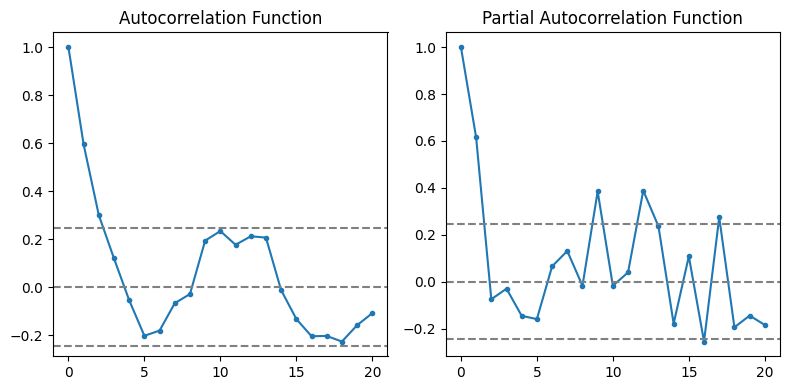

In [ ]:
obtain_order_model(pd.concat([ts_2_train.rain_all,forecast_MA.dropna()]))

7.- Build an **ARIMA** or **SARIMA** model. How does it affect to the **error**?

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:           log_rain_all   No. Observations:                   56
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -41.176
Date:                Mon, 05 Jun 2023   AIC                             88.352
Time:                        18:28:28   BIC                             94.374
Sample:                    05-01-2013   HQIC                            90.680
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5665      0.178      3.182      0.001       0.218       0.915
ma.L1         -1.0000    188.995     -0.005      0.996    -371.422     369.422
sigma2         0.2488     47.001      0.005      0.9

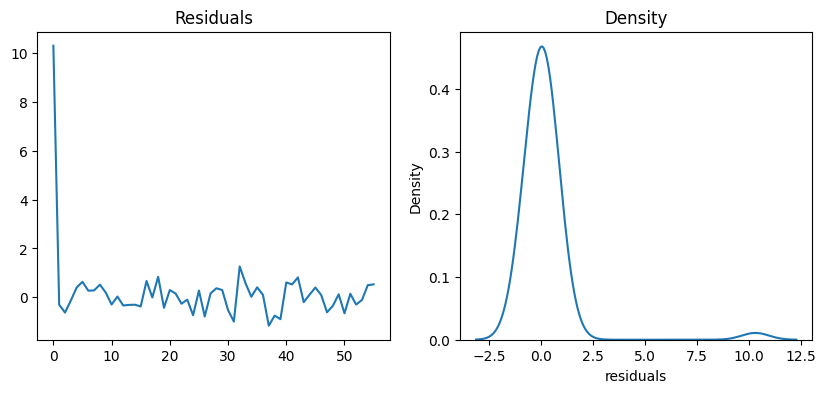

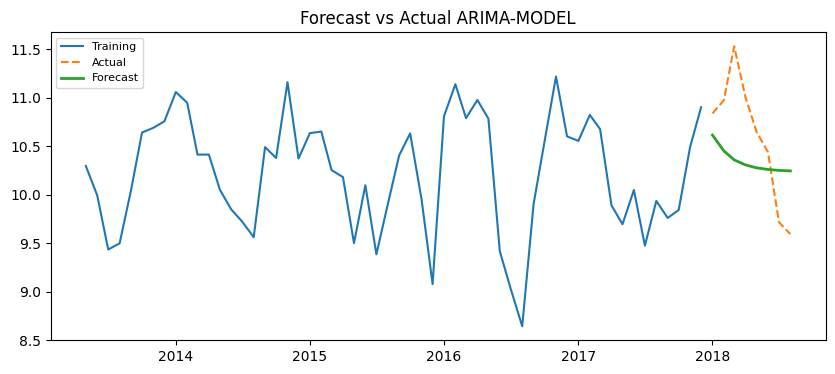

In [ ]:
#modelo ARIMA
model_arima=ARIMA(ts_2_train.log_rain_all.dropna(), order=(1,1,1))#usaré 2 al ver el pacf y acf donde el último delta significativo es 2
model_arima_fitted=model_arima.fit()
print(model_arima_fitted.summary())

#visualizando los residuos
model_summary_results(model_arima_fitted)
#no se observan patrones, y es similar a una distribución gaussiana
forecasting(model_arima_fitted, 8, ts_2_test.log_rain_all, ts_2_train.log_rain_all,"Forecast vs Actual ARIMA-MODEL")
forecast_ARIMA = model_arima_fitted.forecast(8, alpha=0.05)

In [ ]:
#Observando el error
forecast_accuracy(forecast_ARIMA, ts_2_test.log_rain_all)
#Se observa que el error es menor en comparación de los modelos AR Y MA, al igual que benchmark.

{'me': -0.2473743284040797, 'mae': 0.5445410728611533, 'mape': 0.051077152917455806, 'rmse': 0.6193795830661515}


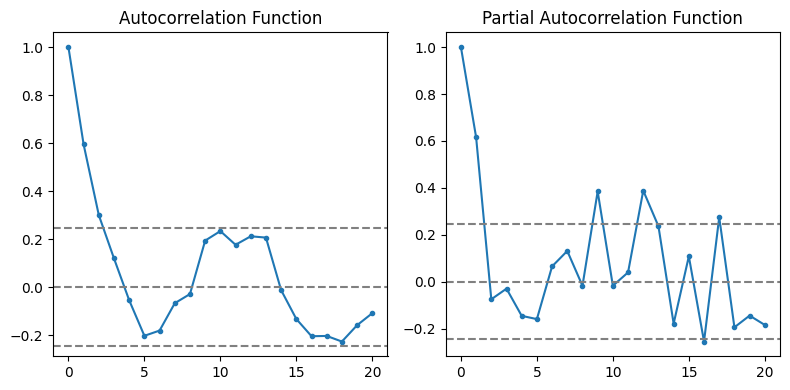

In [ ]:
obtain_order_model(pd.concat([ts_2_train.rain_all,forecast_ARIMA.dropna()]))

In [ ]:
#Modelo SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima = SARIMAX(ts_2_train.log_rain_all.dropna(),
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
model_sarima_fitted = model_sarima.fit()
print(model_sarima_fitted.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                       log_rain_all   No. Observations:                   56
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -31.529
Date:                            Mon, 05 Jun 2023   AIC                             73.058
Time:                                    18:34:47   BIC                             81.864
Sample:                                05-01-2013   HQIC                            76.305
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3830      0.229      1.673      0.094      -0.066       0.832
ma.L1         -0.9971      8.869   

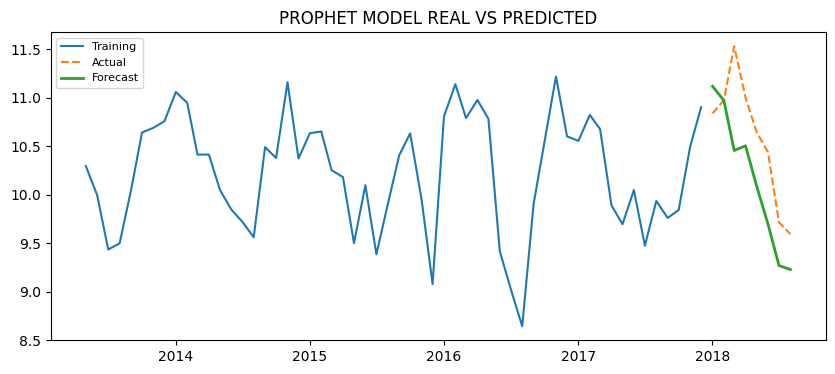

In [ ]:
#forecasting(model_sarima_fitted, 8, ts_2_test.log_rain_all, ts_2_train.log_rain_all,"Forecast vs Actual SARIMA-MODEL")
forecast_SARIMA = model_sarima_fitted.forecast(8, alpha=0.05)
# Convert predictions to series
fc_series = pd.Series(forecast_SARIMA.values, index=forecast_SARIMA.index)


# Plot
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(ts_2_train.log_rain_all, label='Training')
plt.plot(ts_2_test.log_rain_all, linestyle="dashed",label='Actual')
plt.plot(fc_series, linewidth=2,label='Forecast')
plt.title("PROPHET MODEL REAL VS PREDICTED")
plt.legend(loc='best', fontsize=8)
plt.show()  

In [ ]:
#Observando el error
forecast_accuracy(forecast_SARIMA, ts_2_test.log_rain_all)
#Se observa que el error es menor en comparación a todos los anteriores.

{'me': -0.4260542366253208, 'mae': 0.4962878593950073, 'mape': 0.04653999677783825, 'rmse': 0.5788728711607339}


8.- Use **auto_arima** functionality, how does it affect to the **error**?

In [ ]:
!pip install pmdarima
import pmdarima as pm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00


In [ ]:
#Autoarima 
model_autoarima_fitted = pm.auto_arima(ts_2_train.rain_all, 
                                start_p=1, start_q=1, 
                                test='adf',           
                                max_p=3, max_q=3,     
                                m=1,                  
                                d=None,              
                                seasonal=False,       
                                start_P=0,
                                D=0,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
print(model_autoarima_fitted.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1252.586, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1337.178, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1250.766, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1306.436, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1252.572, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1254.204, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1238.650, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1254.163, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1239.136, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1239.651, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1240.313, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1241.487, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.531 seconds
                               SARIMAX Results                                
Dep. Vari

9.- Build a model with **Prophet**, does the **error** increase or decrease?

In [ ]:
!pip install prophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
ts_prophet=pd.read_csv("aemet_year_month.csv", sep=";")
ts_prophet["new_date"]=pd.DatetimeIndex(ts_prophet["new_date"])
ts_prophet=ts_prophet.rename(columns={"new_date":"ds", "rain_all":"y"})
ts_prophet.head(1)

#dividiendo el dataframe
prophet_train=ts_prophet.loc[:,["ds","y"]].iloc[:-8]
prophet_test=ts_prophet.loc[:,["ds","y"]].iloc[-8:]

#fitting
prophet_model=Prophet(interval_width=0.95)
prophet_model.fit(prophet_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zk3yduh/7cpybqrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zk3yduh/h94q_byo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55736', 'data', 'file=/tmp/tmp3zk3yduh/7cpybqrb.json', 'init=/tmp/tmp3zk3yduh/h94q_byo.json', 'output', 'file=/tmp/tmp3zk3yduh/prophet_modelm75ljbah/prophet_model-20230605182855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:28:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#predicción
df_forecast=prophet_model.make_future_dataframe(periods=8, freq='MS')
forecast_PROPHET=prophet_model.predict(df_forecast)
forecast_PROPHET[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].tail(1)

,ds,yhat,yhat_lower,yhat_upper,trend
63,2018-08-01,13369.920361,-5983.226576,32633.767841,36836.273032


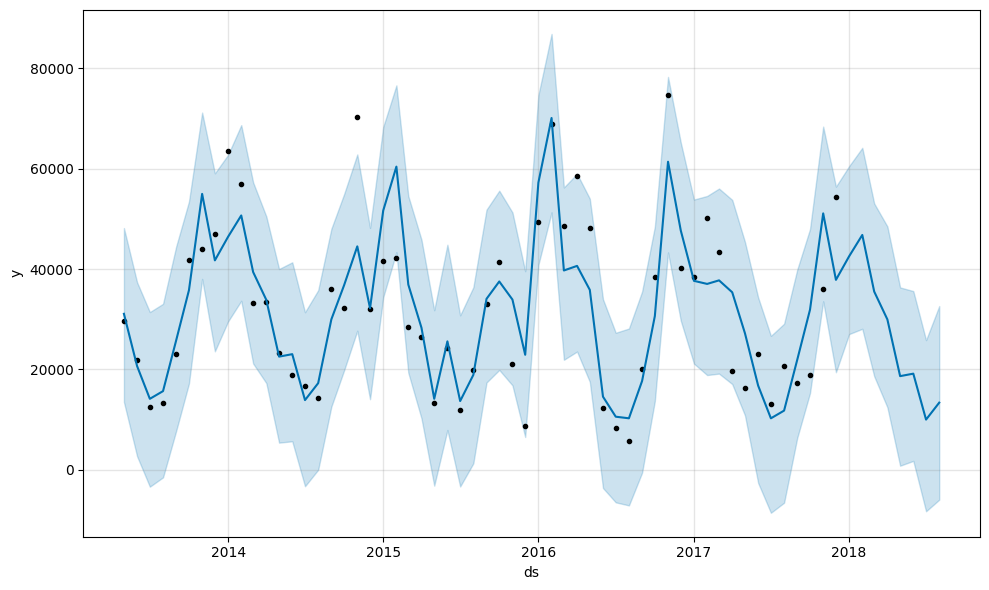

In [ ]:
prophet_model.plot(forecast_PROPHET, uncertainty=True);


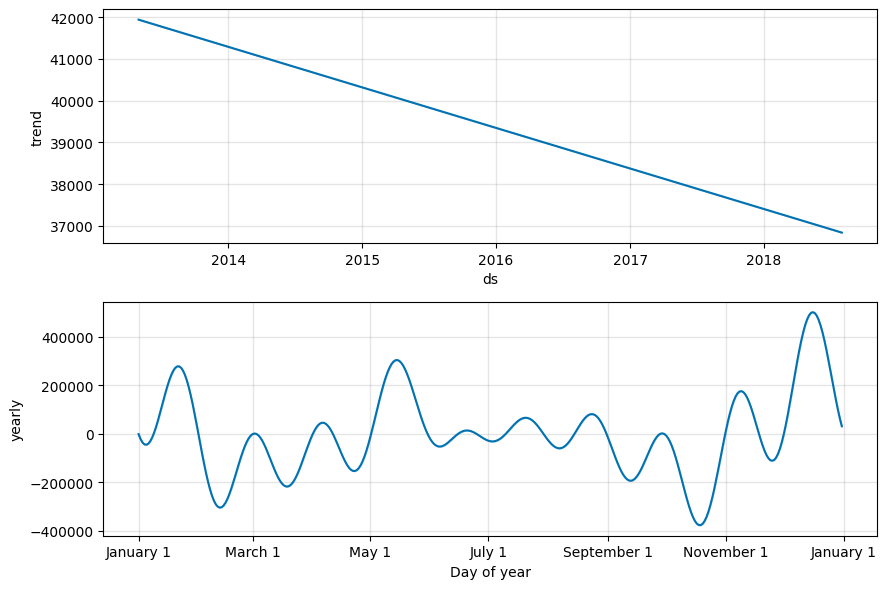

In [ ]:
prophet_model.plot_components(forecast_PROPHET);

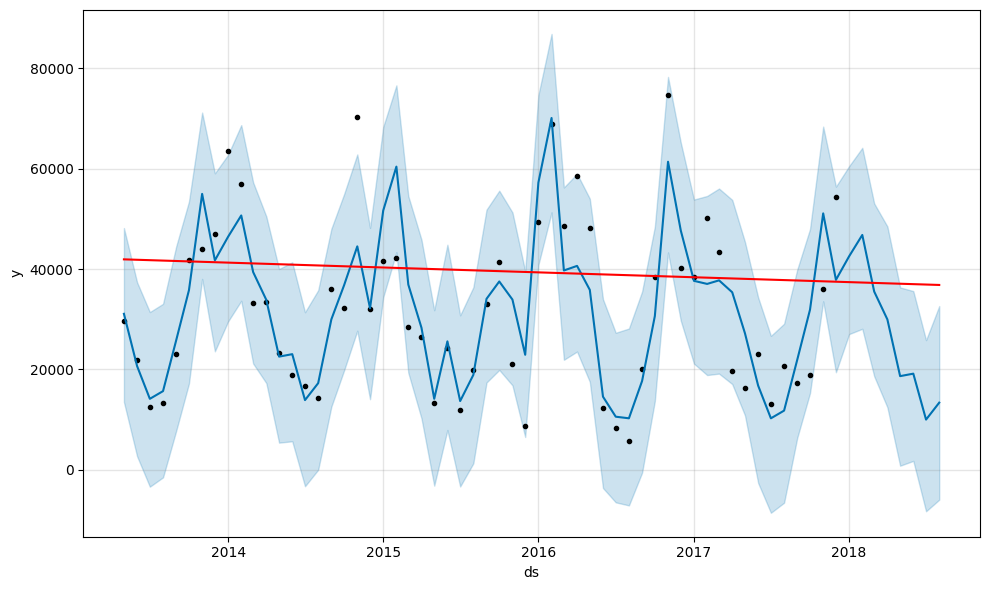

In [ ]:
fig = prophet_model.plot(forecast_PROPHET)
a = add_changepoints_to_plot(fig.gca(), prophet_model, forecast_PROPHET)

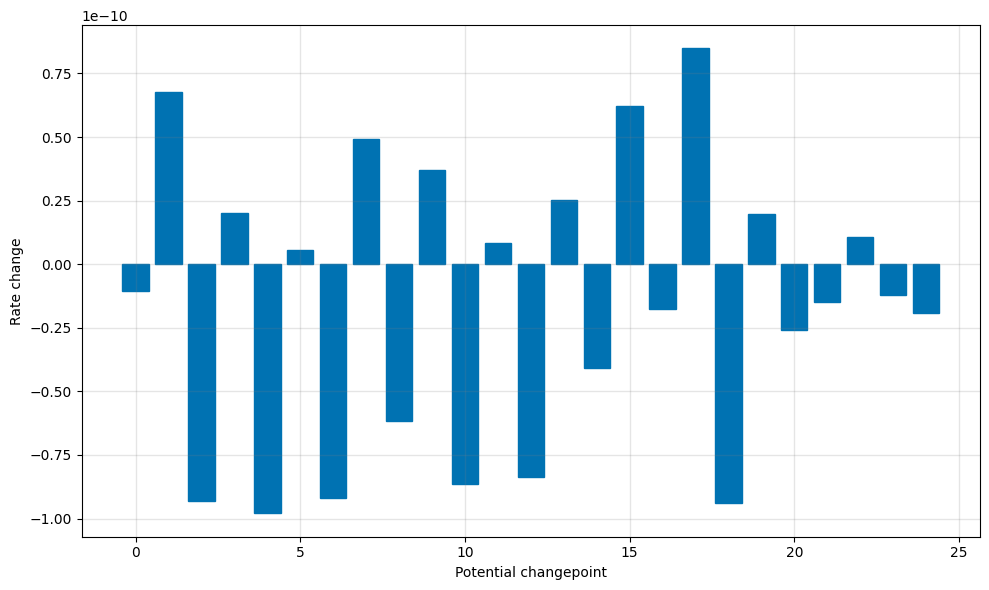

In [ ]:
deltas = prophet_model.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()


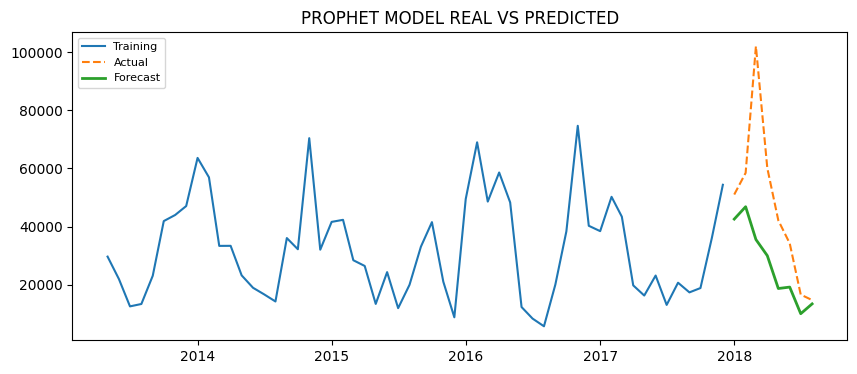

In [ ]:


# Convert predictions to series
fc_series_prophet = pd.Series(forecast_PROPHET.yhat.iloc[-8:].values, index=forecast_PROPHET.ds.iloc[-8:])
forecast_PROPHET_=fc_series_prophet
# Plot
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(prophet_train.ds.values,prophet_train.y.values, label='Training')
plt.plot(prophet_test.ds.values,prophet_test.y.values, linestyle="dashed",label='Actual')
plt.plot(fc_series_prophet, linewidth=2,label='Forecast')
plt.title("PROPHET MODEL REAL VS PREDICTED")
plt.legend(loc='best', fontsize=8)
plt.show()  

In [ ]:
forecast_accuracy(np.log(forecast_PROPHET_), ts_2_test.log_rain_all)
#El SARIMA es levemente mejor, al tener un menor error, pero están muy cercanos.

{'me': -0.5183278102608453, 'mae': 0.5183278102608453, 'mape': 0.0481738620095072, 'rmse': 0.6065096153228842}


10.- Finally, which is the **best** model?

In [ ]:
forecast_models_result=pd.DataFrame(data={"y_hat_mean_last_n":forecast_BANCHMARK_y_hat_mean_last_n,"y_hat_naive_seasonal":forecast_BANCHMARK_y_hat_naive_seasonal,"AR_MODEL":forecast_AR.values,"MA_MODEL":forecast_MA.values,"ARIMA_MODEL":forecast_ARIMA.values,
                                          "SARIMA_MODEL":forecast_SARIMA.values,"PROPHET_MODEL":np.log(forecast_PROPHET_.values),"TEST_VALUES":np.log(ts_2_test.rain_all)})

                            

In [ ]:
forecast_models_result

,y_hat_mean_last_n,y_hat_naive_seasonal,AR_MODEL,MA_MODEL,ARIMA_MODEL,SARIMA_MODEL,PROPHET_MODEL,TEST_VALUES
new_date,,,,,,,,
2018-01-01,10.018935,9.695109,10.618800,10.689867,10.615269,11.120508,10.658421,10.839573
2018-02-01,10.018935,10.048514,10.332280,10.376818,10.452070,10.973353,10.753760,10.975932
2018-03-01,10.018935,9.473804,10.207903,10.234800,10.359613,10.456671,10.477869,11.532983
2018-04-01,10.018935,9.935684,10.192214,10.234800,10.307234,10.505124,10.307809,11.003640
2018-05-01,10.018935,9.760137,10.210968,10.234800,10.277559,10.091033,9.833945,10.647948
2018-06-01,10.018935,9.842686,10.227172,10.234800,10.260747,9.697446,9.860034,10.440077
2018-07-01,10.018935,10.492207,10.233581,10.234800,10.251223,9.268689,9.209313,9.714830
2018-08-01,10.018935,10.903336,10.234051,10.234800,10.245827,9.227280,9.500763,9.593553


In [ ]:
for model in forecast_models_result.columns[:-1]:
  print(model, end=":               ")
  forecast_accuracy(forecast_models_result[model], forecast_models_result["TEST_VALUES"])
"""RESULTADO: SARIMA MODEL ES EL QUE TIENE EL MENOR MAPE"""

y_hat_mean_last_n:               {'me': -0.5746324875774589, 'mae': 0.7570040377053402, 'mape': 0.06984041597388349, 'rmse': 0.8439288701432301}
y_hat_naive_seasonal:               {'me': -0.5746324875774582, 'mae': 1.0964225209304481, 'mape': 0.10285325607298633, 'rmse': 1.1734342099276267}
AR_MODEL:               {'me': -0.31144605818797366, 'mae': 0.6012582625654752, 'mape': 0.056154889706340104, 'rmse': 0.688558311034097}
MA_MODEL:               {'me': -0.2841315263761499, 'mae': 0.5744357470959216, 'mape': 0.053707180443018296, 'rmse': 0.6663464704012195}
ARIMA_MODEL:               {'me': -0.2473743284040797, 'mae': 0.5445410728611533, 'mape': 0.051077152917455806, 'rmse': 0.6193795830661515}
SARIMA_MODEL:               {'me': -0.4260542366253208, 'mae': 0.4962878593950073, 'mape': 0.04653999677783825, 'rmse': 0.5788728711607339}
PROPHET_MODEL:               {'me': -0.5183278102608453, 'mae': 0.5183278102608453, 'mape': 0.0481738620095072, 'rmse': 0.6065096153228842}


'RESULTADO: SARIMA MODEL ES EL QUE TIENE EL MENOR MAPE'